# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.

## Vectorstore retrieval


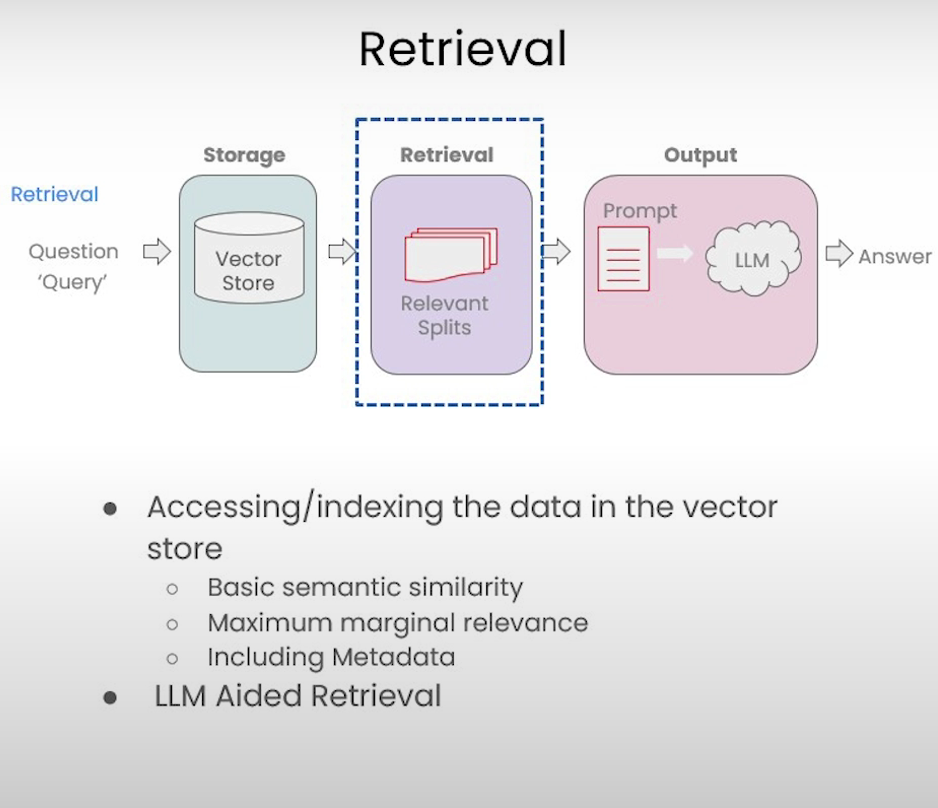

In [ ]:
#!pip install lark

### Similarity Search

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
persist_directory = 'data/docs/chroma/'

In [2]:
embedding = OpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [3]:
print(vectordb._collection.count())

209


In [ ]:
!rm -rf ./data/docs/chroma  # remove old database files if any

In [4]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [5]:
smalldb = Chroma.from_texts(texts, embedding=embedding)

In [6]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [7]:
smalldb.similarity_search(question, k=2)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [8]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

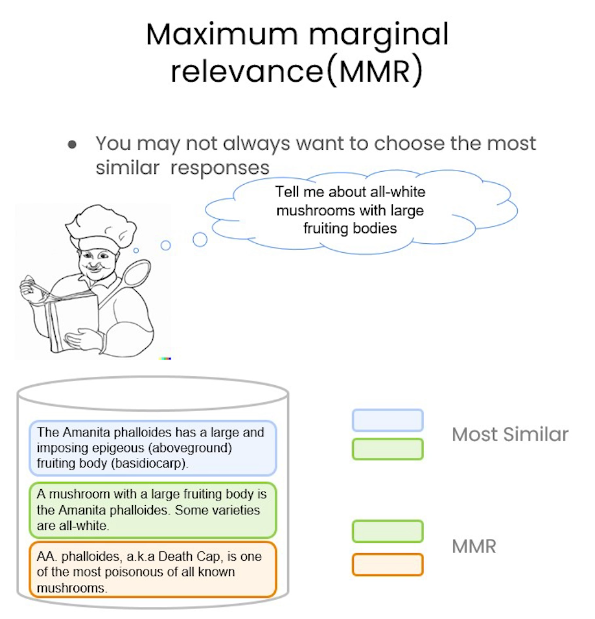

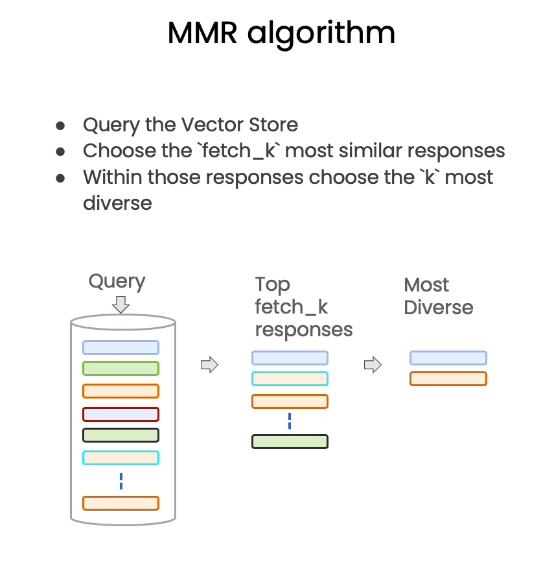

In [9]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [10]:
docs_ss[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [11]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

Note the difference in results with `MMR`.

In [12]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [13]:
docs_mmr[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [14]:
docs_mmr[1].page_content[:100]

'algorithm then? So what’s different? How come  I was making all that noise earlier about \nleast squa'

### Addressing Specificity: working with metadata

In last lecture, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

In [18]:
question = "what did they say about regression in the third lecture?"

In [19]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"data/docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

In [20]:
for d in docs:
    print(d.metadata)

{'page': 0, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 14, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 4, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}


### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

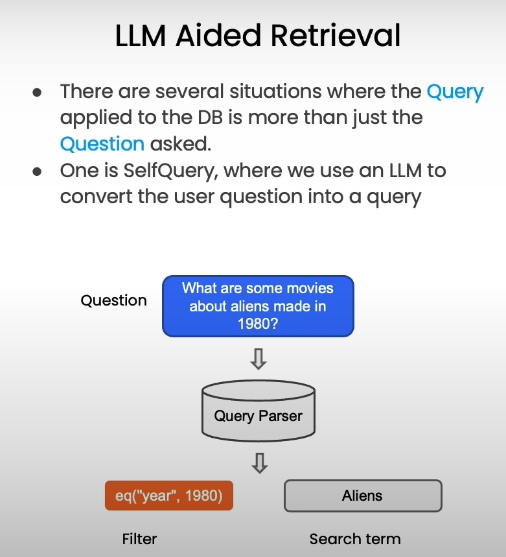

In [21]:
from langchain_openai import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [22]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `data/docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `data/docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `data/docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

In [23]:
document_content_description = "Lecture notes"
llm = OpenAI(model='gpt-3.5-turbo-instruct', temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [24]:
question = "what did they say about regression in the third lecture?"

In [31]:
docs = retriever.get_relevant_documents(question)
docs

[Document(metadata={'page': 14, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}, page_content='Student: It’s the lowest it –  \nInstructor (Andrew Ng) :No, exactly. Right. So zero to the same, this is not the same, \nright? And the reason is, in logi stic regression this is diffe rent from before, right? The \ndefinition of this H subscript theta of XI is not the same as the definition I was using in \nthe previous lecture. And in pa rticular this is no longer thet a transpose XI. This is not a \nlinear function anymore. This is  a logistic function of theta transpose XI. Okay? So even \nthough this looks cosmetically similar, even though this is similar on the surface, to the \nBastrian descent rule I derive d last time for least squares regression this is actually a \ntotally different learning algorithm. Okay? And it turns out that there’s actually no \ncoincidence that you ended up with the same l earning rule. We’ll actually talk a bit more \nabout this later w

In [32]:
for d in docs:
    print(d.metadata)

{'page': 14, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 10, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 0, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 10, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture03.pdf'}


### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression.

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

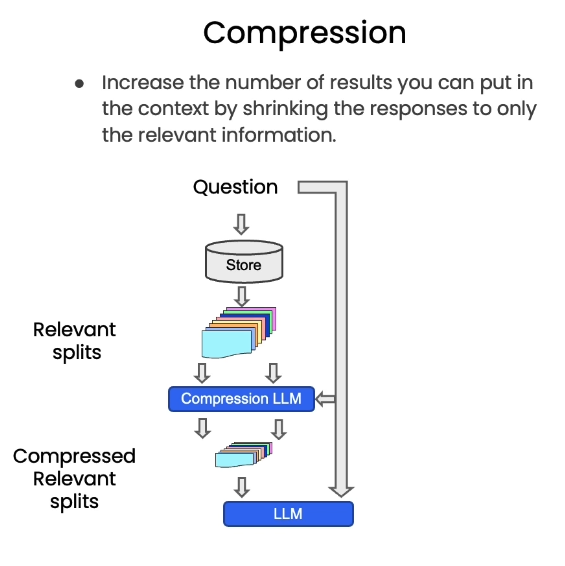

In [33]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
# extract only the relevant bits from each document and pass those as teh final return response

In [34]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [35]:
# Wrap our vectorstore
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct")
compressor = LLMChainExtractor.from_llm(llm)

In [36]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [37]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write 

## Combining various techniques

In [38]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [39]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

"Oh, it was the MATLAB."
----------------------------------------------------------------------------------------------------
Document 3:

- learning algorithms to teach a car how to drive at reasonably high 

## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [40]:
from langchain_community.retrievers import SVMRetriever
from langchain_community.retrievers import TFIDFRetriever
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [41]:
# Load PDF
loader = PyPDFLoader("data/docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [42]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [45]:
question = "what did they say about matlab?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

Document(page_content='don\'t have a MATLAB license, for the purposes of  this class, there\'s also — [inaudible] \nwrite that down [inaudible] MATLAB — there\' s also a software package called Octave \nthat you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it\'s free, and for the purposes of  this class, it will work for just about \neverything.  \nSo actually I, well, so yeah, just a side comment for those of you that haven\'t seen \nMATLAB before I guess, once a colleague of mine at a different university, not at \nStanford, actually teaches another machine l earning course. He\'s taught it for many years. \nSo one day, he was in his office, and an old student of his from, lik e, ten years ago came \ninto his office and he said, "Oh, professo r, professor, thank you so much for your \nmachine learning class. I learned so much from it. There\'s this stuff that I learned in your \nclass, and I now use every day. And it\'s help ed me make l

In [46]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]

Document(page_content="Saxena and Min Sun here did, wh ich is given an image like this, right? This is actually a \npicture taken of the Stanford campus. You can apply that sort of cl ustering algorithm and \ngroup the picture into regions. Let me actually blow that up so that you can see it more \nclearly. Okay. So in the middle, you see the lines sort of groupi ng the image together, \ngrouping the image into [inaudible] regions.  \nAnd what Ashutosh and Min did was they then  applied the learning algorithm to say can \nwe take this clustering and us e it to build a 3D model of the world? And so using the \nclustering, they then had a lear ning algorithm try to learn what the 3D structure of the \nworld looks like so that they could come up with a 3D model that you can sort of fly \nthrough, okay? Although many people used to th ink it's not possible to take a single \nimage and build a 3D model, but using a lear ning algorithm and that sort of clustering \nalgorithm is the first ste